In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
from transformers import LevitForImageClassification, LevitConfig, LevitForImageClassificationWithTeacher
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torchvision import models

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


C:\Users\dmpoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
# !unzip '/content/drive/MyDrive/ML Project - Dump/archive.zip'

In [4]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Function to get predictions and probabilities
def get_predictions_and_probabilities(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {model.__class__.__name__}", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits
            probs = softmax(outputs, dim=1)[:, 1]  # Probability for class '1'
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.view(-1).cpu().numpy())
            actuals.extend(labels.view(-1).cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    return predictions, actuals, probabilities


Using device: cuda


In [17]:
import os
from PIL import Image
from torch.utils.data import Dataset

class RealVFakeDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []

        for label, subdir in enumerate(['real', 'fake']):
            subdir_path = os.path.join(directory, subdir)
            for img_file in os.listdir(subdir_path):
                self.images.append(os.path.join(subdir_path, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [7]:
# Create a DataLoader for the test dataset
test_dataset = RealVFakeDataset(r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\Final_old\Final\test', transform)  # Replace with your test dataset path
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # No need to shuffle for testing



In [8]:


# Load pre-trained model configuration
config3 = LevitConfig.from_pretrained("facebook/levit-128S")
config3.num_labels = 2  # Update number of classes

# Load pre-trained model with updated configuration
model3 = LevitForImageClassification(config=config3)

# Load your custom trained weights for the model
model3.load_state_dict(torch.load(r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\final_model_scartch_LeViT_state.pth', map_location=device), strict=False)
model3.to(device)



LevitForImageClassification(
  (levit): LevitModel(
    (patch_embeddings): LevitPatchEmbeddings(
      (embedding_layer_1): LevitConvEmbeddings(
        (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_1): Hardswish()
      (embedding_layer_2): LevitConvEmbeddings(
        (convolution): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_2): Hardswish()
      (embedding_layer_3): LevitConvEmbeddings(
        (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_3): Hardswish()
      

In [9]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

test_dataset = RealVFakeDataset(r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\Final_old\Final\test', transform)
test_loader = DataLoader(test_dataset, batch_size=32)


In [10]:

# Get predictions and actuals for each model
predictions3, actuals3, probabilities3 = get_predictions_and_probabilities(model3, test_loader)


Evaluating LevitForImageClassification: 100%|██████████| 725/725 [04:17<00:00,  2.82batch/s]


Model 3 test Accuracy: 0.9212432106216053
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     11500
           1       0.90      0.95      0.92     11698

    accuracy                           0.92     23198
   macro avg       0.92      0.92      0.92     23198
weighted avg       0.92      0.92      0.92     23198

Model 3 - AUC Score: 0.9803725162978434 AP Score: 0.9826216848484659


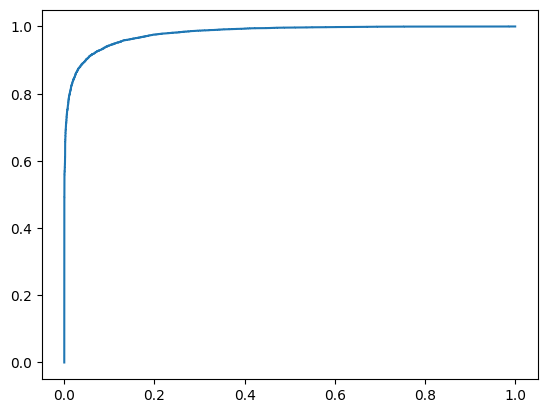

In [11]:
accuracy3 = accuracy_score(actuals3, predictions3)
print("Model 3 test Accuracy:", accuracy3)
print(classification_report(actuals3, predictions3))


auc_score3 = roc_auc_score(actuals3, probabilities3)
ap_score3 = average_precision_score(actuals3, probabilities3)
print("Model 3 - AUC Score:", auc_score3, "AP Score:", ap_score3)

fpr3, tpr3, _ = roc_curve(actuals3, probabilities3)
plt.plot(fpr3, tpr3, label='Model 3')

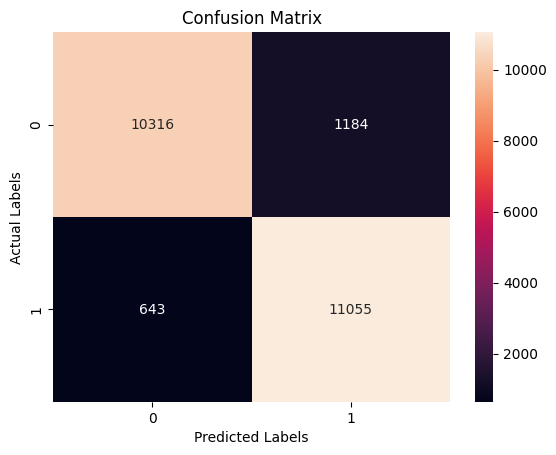

In [12]:
# Assuming actuals1 and predictions1 are defined from your previous code
cm = confusion_matrix(actuals3, predictions3)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [18]:


# Load pre-trained model configuration
config4= LevitConfig.from_pretrained("facebook/levit-128S")
config4.num_labels = 2  # Update number of classes

# Load pre-trained model with updated configuration
# model = LevitForImageClassification.from_pretrained("facebook/levit-128S", config=config, ignore_mismatched_sizes=True)
model4 = LevitForImageClassificationWithTeacher(config=config4)


# Load your custom trained weights for the model
model4.load_state_dict(torch.load(r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\final_model_TEACHER_scartch_LeViT_state.pth', map_location=device), strict=False)
model4.to(device)



LevitForImageClassificationWithTeacher(
  (levit): LevitModel(
    (patch_embeddings): LevitPatchEmbeddings(
      (embedding_layer_1): LevitConvEmbeddings(
        (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_1): Hardswish()
      (embedding_layer_2): LevitConvEmbeddings(
        (convolution): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_2): Hardswish()
      (embedding_layer_3): LevitConvEmbeddings(
        (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_3): Hardswi

In [19]:

# Get predictions and actuals for each model
predictions4, actuals4, probabilities4 = get_predictions_and_probabilities(model4, test_loader)


Evaluating LevitForImageClassificationWithTeacher:   0%|          | 0/725 [00:00<?, ?batch/s]

Evaluating LevitForImageClassificationWithTeacher: 100%|██████████| 725/725 [03:31<00:00,  3.43batch/s]


Model 4 test Accuracy: 0.9343477886024657
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11500
           1       0.95      0.91      0.93     11698

    accuracy                           0.93     23198
   macro avg       0.93      0.93      0.93     23198
weighted avg       0.94      0.93      0.93     23198

Model 4 - AUC Score: 0.9803725162978434 AP Score: 0.9826216848484659


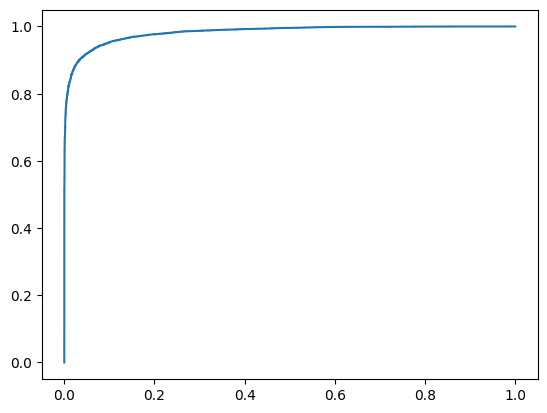

In [22]:
accuracy4 = accuracy_score(actuals4, predictions4)
print("Model 4 test Accuracy:", accuracy4)
print(classification_report(actuals4, predictions4))


auc_score4 = roc_auc_score(actuals4, probabilities4)
ap_score4 = average_precision_score(actuals4, probabilities4)
print("Model 4 - AUC Score:", auc_score3, "AP Score:", ap_score3)

fpr4, tpr4, _ = roc_curve(actuals3, probabilities4)
plt.plot(fpr4, tpr4, label='Model 4')

In [23]:
# Calculate AUC score for each model
auc1 = roc_auc_score(actuals3, probabilities3)
auc2 = roc_auc_score(actuals4, probabilities4)

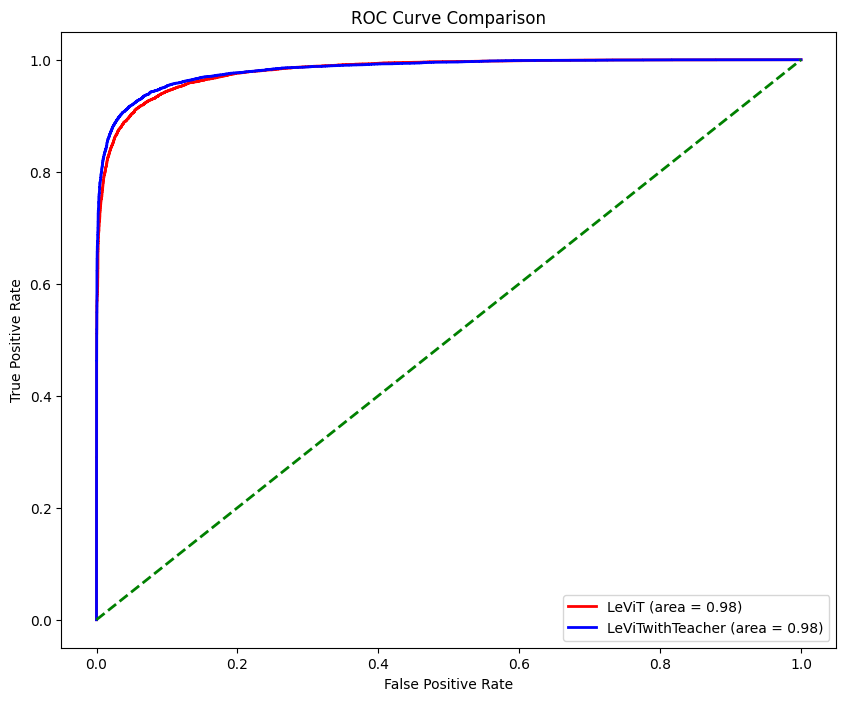

In [24]:
# Assuming fpr1, tpr1, roc_auc1, etc., are already calculated as shown previously

# Plot ROC curves with updated labels
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr3, tpr3, color='red', lw=lw, label=f'LeViT (area = {auc1:.2f})')
plt.plot(fpr4, tpr4, color='blue', lw=lw, label=f'LeViTwithTeacher (area = {auc2:.2f})')
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()
